<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Sprint Challenge
## *Data Science Unit 4 Sprint 1*

After a week of Natural Language Processing, you've learned some cool new stuff: how to process text, how turn text into vectors, and how to model topics from documents. Apply your newly acquired skills to one of the most famous NLP datasets out there: [Yelp](https://www.yelp.com/dataset/challenge). As part of the job selection process, some of my friends have been asked to create analysis of this dataset, so I want to empower you to have a head start.  

The real dataset is massive (almost 8 gigs uncompressed). I've sampled the data for you to something more managable for the Sprint Challenge. You can analyze the full dataset as a stretch goal or after the sprint challenge. As you work on the challenge, I suggest adding notes about your findings and things you want to analyze in the future.

## Challenge Objectives
*Successfully complete these all these objectives to earn a 2. There are more details on each objective further down in the notebook.*
* <a href="#p1">Part 1</a>: Write a function to tokenize the yelp reviews
* <a href="#p2">Part 2</a>: Create a vector representation of those tokens
* <a href="#p3">Part 3</a>: Use your tokens in a classification model on yelp rating
* <a href="#p4">Part 4</a>: Estimate & Interpret a topic model of the Yelp reviews

In [1]:
import pandas as pd

yelp = pd.read_json('./data/review_sample.json', lines=True)

In [2]:
yelp.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA


In [3]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

C:\Users\mhdal\Anaconda3\envs\lambda-nlp\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
import warnings
warnings.filterwarnings('ignore')

## Part 1: Tokenize Function
<a id="#p1"></a>

Complete the function `tokenize`. Your function should
- accept one document at a time
- return a list of tokens

You are free to use any method you have learned this week.

In [19]:
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

nlp = spacy.load("en_core_web_lg")

In [20]:
tokenizer = Tokenizer(nlp.vocab)

In [21]:
STOP_WORDS = nlp.Defaults.stop_words.union([' ','I', 'i', 'and', 'it', "it's", 'it.', 'the', 'this','of', 'is', 'my', 'but'])

In [23]:
# Tokenizer Pipe

tokens = []

""" Make them tokens """
for doc in tokenizer.pipe(yelp['text'], batch_size=500):
    doc_tokens = []
    for token in doc[1:]:
        if token.text not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
    tokens.append(doc_tokens)
        
            
yelp['tokens'] = tokens

In [24]:
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

In [25]:
yelp['lemmas'] = yelp['text'].apply(get_lemmas)

In [128]:
get_lemmas("gggg")

['gggg']

0    [beware, fake, fake, fake, small, business, lo...
1    [came, lunch, togo, service, quick, staff, fri...
2    [ve, vegas, dozens, times, stepped, foot, circ...
3    [went, night, closed, street, party, best, act...
4    [stars, bad, price, lunch, seniors, pay, eatin...
Name: tokens, dtype: object

In [27]:
list_string = []
for i in yelp['lemmas']:
    stringe = ""
    for string in i:
        stringe = stringe + ' ' + string
    list_string.append(stringe)

In [29]:
yelp['lammatized_sentence'] = list_string

## Part 2: Vector Representation
<a id="#p2"></a>
1. Create a vector representation of the reviews
2. Write a fake review and query for the 10 most similiar reviews, print the text of the reviews. Do you notice any patterns?
    - Given the size of the dataset, it will probably be best to use a `NearestNeighbors` model for this. 

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

# create the transformer
vectorizer = CountVectorizer(stop_words='english', min_df = 0.05, max_df= 0.90)

# tokenize and build vocab
vectorizer.fit(yelp['lammatized_sentence'])


# Create a Vocabulary
# The vocabulary establishes all of the possible words that we might use.
vectorizer.vocabulary_

sparse_dtm = vectorizer.transform(yelp['lammatized_sentence'])
# The vocabulary dictionary does not represent the counts of words!!
dtm = pd.DataFrame(sparse_dtm.todense(), columns=vectorizer.get_feature_names())

In [36]:
dtm.head()

,10,amazing,area,ask,away,awesome,bad,bar,big,bit,...,vegas,visit,wait,walk,want,way,week,work,worth,year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,1,0,0,...,2,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,2,0,1,...,0,0,0,0,0,0,0,0,0,0


In [37]:
##### Your Code Here #####
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words = 'english',min_df = 0.05, max_df= 0.90)

# Create a vocabulary and get word counts per document
sparse = tfidf.fit_transform(yelp['lammatized_sentence'])

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(sparse.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,10,amazing,area,ask,away,awesome,bad,bar,big,bit,...,vegas,visit,wait,walk,want,way,week,work,worth,year
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.277132,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
2,0.0,0.0,0.125276,0.0,0.0,0.0,0.000000,0.123349,0.0,0.000000,...,0.251037,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.11979
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.200043,0.434745,0.0,0.221628,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000


In [38]:
# Instantiate
from sklearn.neighbors import NearestNeighbors


# Fit on TF-IDF Vectors
nn  = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nn.fit(dtm)


NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [73]:
Fake_review = ["The stay was horrible, and the staff was rude. Nevertheless the location was central. I do not recommend for families"]

In [43]:
new = tfidf.transform(Fake_review)

nn.kneighbors(new.todense())

(array([[0.68133685, 0.72988798, 0.74850749, 0.83068955, 0.83187473]]),
 array([[7367, 9289, 3400, 8699, 7040]], dtype=int64))

In [61]:
for i in nn.kneighbors(new.todense())[1]:
    print(yelp['text'].iloc[i])

7367    I didn't get stabbed and they do have one heck...
9289    Ok, brand new place, less than a mile from our...
3400    This location has new machines and is very cle...
8699    i love home depot. and i am there very often.\...
7040    Not a very good location.  My steak wasn't up ...
Name: text, dtype: object


In [64]:
yelp['text'].iloc[7040]

"Not a very good location.  My steak wasn't up to par with the other Outbacks I have been to."

In [60]:
pd.options.display.max_seq_items = 2000


## Part 3: Classification
<a id="#p3"></a>
Your goal in this section will be to predict `stars` from the review dataset. 

1. Create a piepline object with a sklearn `CountVectorizer` or `TfidfVector` and any sklearn classifier. Use that pipeline to estimate a model to predict `stars`. Use the Pipeline to predict a star rating for your fake review from Part 2. 
2. Tune the entire pipeline with a GridSearch

In [85]:
# Import Statements
from sklearn.pipeline import Pipeline

from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score


In [66]:
vect = TfidfVectorizer(stop_words = 'english')
sgdc = SGDClassifier()

pipe = Pipeline([('vect', vect), ('clf', sgdc)])

In [92]:
X_train, X_test, y_train, y_test = train_test_split(yelp['lammatized_sentence'], yelp['stars'], train_size=0.8)

In [68]:
pipe.fit(yelp['lammatized_sentence'], yelp['stars'])

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])

In [70]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'vect__max_features': (100, 500, 1000),
    'clf__max_iter':(20, 10, 1000)
}
grid_search = GridSearchCV(pipe,parameters, cv=7, n_jobs=-1, verbose=1)
grid_search.fit(yelp['lammatized_sentence'], yelp['stars'])


Fitting 7 folds for each of 27 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:  2.2min finished


GridSearchCV(cv=7, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'vect__max_df': (0.5, 0.75, 1.0), 'vect__max_features': (100, 500, 1000), 'clf__max_iter': (20, 10, 1000)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [91]:
grid_search.score(yelp['lammatized_sentence'], yelp['stars'])

0.6953

In [90]:
cross_val_score(grid_search, yelp['lammatized_sentence'], yelp['stars']) 

Fitting 7 folds for each of 27 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:  1.2min finished


Fitting 7 folds for each of 27 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:  1.3min finished


Fitting 7 folds for each of 27 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:  1.3min finished


array([0.58710645, 0.57905791, 0.59303721])

In [94]:
y_pred = pipe.predict(Fake_review)
y_pred

array([1], dtype=int64)

## Part 4: Topic Modeling

Let's find out what those yelp reviews are saying! :D

1. Estimate a LDA topic model of the review text
2. Create 1-2 visualizations of the results
    - You can use the most important 3 words of a topic in relevant visualizations. Refer to yesterday's notebook to extract. 
3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

__*Note*__: You can pass the DataFrame column of text reviews to gensim. You do not have to use a generator.

In [97]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

In [98]:
def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [99]:
STOPWORDS = set(STOPWORDS).union(set(['review','reviews']))
def doc_stream(df):
    for i in range(len(df)):
        tokens = tokenize(str(df[i]))
        yield tokens

In [105]:
id2word = corpora.Dictionary(doc_stream(yelp['lammatized_sentence']))


In [108]:
len(id2word.keys())

21884

In [109]:
corpus = [id2word.doc2bow(text) for text in doc_stream(yelp['lammatized_sentence'])]


In [110]:
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 2),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 3),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 2),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 2),
 (22, 1),
 (23, 3),
 (24, 1),
 (25, 2),
 (26, 2),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 1)]

In [123]:
warnings.filterwarnings('ignore')


In [129]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 5,
                   passes=10,
                   workers=6
                  )

In [130]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]
topics = [' '.join(t[0:5]) for t in words]

In [131]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [132]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.112219  0.008176       1        1  36.689983
2      0.117946 -0.007880       2        1  20.909853
3      0.044229  0.015555       3        1  19.076868
1     -0.031540 -0.066067       4        1  14.949944
0     -0.018416  0.050217       5        1   8.373352, topic_info=      Category          Freq           Term         Total  loglift  logprob
26     Default  21214.000000           pron  21214.000000  30.0000  30.0000
120    Default   5157.000000          place   5157.000000  29.0000  29.0000
350    Default    795.000000          pizza    795.000000  28.0000  28.0000
130    Default   5100.000000           food   5100.000000  27.0000  27.0000
38     Default   7230.000000           good   7230.000000  26.0000  26.0000
35     Default   3677.000000           come   3677.000000  25.0000  25.0000
693    Default    696.000000            car    696.000000  24.0000  24.0000
32     Default   4075.000000           time   4075.000000  23.0000  23.0000
661    Default    512.000000          sushi    512.000000  22.0000  22.0000
617    Default   2139.000000           love   2139.000000  21.0000  21.0000
94     Default   1065.000000           room   1065.000000  20.0000  20.0000
188    Default   4216.000000          great   4216.000000  19.0000  19.0000
294    Default   1445.000000           work   1445.000000  18.0000  18.0000
316    Default   1241.000000      delicious   1241.000000  17.0000  17.0000
93     Default   1770.000000     restaurant   1770.000000  16.0000  16.0000
451    Default   1435.000000           tell   1435.000000  15.0000  15.0000
442    Default    520.000000           roll    520.000000  14.0000  14.0000
1076   Default   1462.000000        chicken   1462.000000  13.0000  13.0000
388    Default   1157.000000       customer   1157.000000  12.0000  12.0000
344    Default   3443.000000          order   3443.000000  11.0000  11.0000
603    Default    582.000000           beer    582.000000  10.0000  10.0000
413    Default   1549.000000           know   1549.000000   9.0000   9.0000
684    Default    805.000000          store    805.000000   8.0000   8.0000
118    Default   1336.000000         people   1336.000000   7.0000   7.0000
1615   Default    492.000000          hotel    492.000000   6.0000   6.0000
829    Default    541.000000       sandwich    541.000000   5.0000   5.0000
763    Default    287.000000         buffet    287.000000   4.0000   4.0000
133    Default   1163.000000            fry   1163.000000   3.0000   3.0000
44     Default   1509.000000          staff   1509.000000   2.0000   2.0000
260    Default    312.000000           nail    312.000000   1.0000   1.0000
2894    Topic1     59.324036          asada     62.656490   0.9480  -7.9987
8581    Topic1     22.068649     yellowtail     23.321573   0.9474  -8.9875
2400    Topic1    106.110115        sashimi    112.453804   0.9446  -7.4172
2895    Topic1     66.987350          carne     71.092529   0.9432  -7.8772
469     Topic1     87.646683       tortilla     93.077873   0.9425  -7.6084
5661    Topic1     33.779510        tartare     35.957100   0.9402  -8.5619
4159    Topic1     28.618282          katsu     30.532919   0.9379  -8.7277
168     Topic1    473.626251           taco    506.815094   0.9349  -5.9213
2284    Topic1    202.427887           thai    216.994492   0.9332  -6.7713
8053    Topic1     23.682104       macaroni     25.398195   0.9327  -8.9170
4757    Topic1     13.727654       peruvian     14.793698   0.9279  -9.4623
9639    Topic1     10.789989           mahi     11.641617   0.9267  -9.7031
3663    Topic1     24.443634           taro     26.411684   0.9252  -8.8853
3815    Topic1     24.281404  mediterranean     26.254759   0.9245  -8.8920
4505    Topic1     17.556400       hazelnut     19.006464   0.9233  -9.2163
6477    Topic1     11.685089          savor     12.657289   0.9227  -9.6234
10590  

In [115]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, path, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        stream = doc_stream(path)
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word, workers=6)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=stream, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:

model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        path=yelp['lammatized_sentence'], 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6)

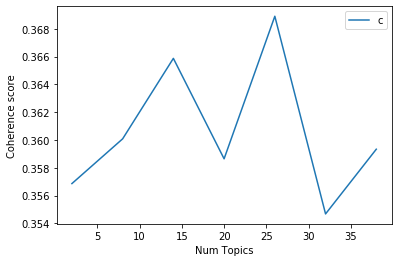

In [118]:
# Show graph
%matplotlib inline
import matplotlib.pyplot as plt

limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig('Coherenece Yelp.png')
plt.show()

We have two graphs, one that indicates the different topics. The fact the no topic is overlapping with another is a good thing, that means that we were able to create sperate topic clouds. the second plot shows the coherence level and each number of topics, if we decide to split the topics to any of thos numbers. For example at 25 topics the coherence level is at its heighest.

## Stretch Goals

Complete one of more of these to push your score towards a three: 
* Incorporate named entity recognition into your analysis
* Compare vectorization methods in the classification section
* Analyze more (or all) of the yelp dataset - this one is v. hard. 
* Use a generator object on the reviews file - this would help you with the analyzing the whole dataset.
* Incorporate any of the other yelp dataset entities in your analysis (business, users, etc.)